In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing libraries pandas and numpy. Importing historical_data.csv and displaying the column data.


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

historical_data='/content/drive/MyDrive/historical_data.csv'

trades = pd.read_csv(historical_data)
trades.head()



,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


Check for missing values

In [58]:
print("\nMissing Values:")
print(trades.isnull().sum())


Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Importing fear_greed_index.csv

In [59]:
Fear_greed = '/content/drive/MyDrive/fear_greed_index.csv'
sentiment=pd.read_csv(Fear_greed)
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Checking for missing values

In [60]:
print("\nMissing Values:")
print(sentiment.isnull().sum())


Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64


.shape was used to check number of rows and columns .Check for data cleanliness to verify whether there is missing or duplicate values.

In [61]:
print(trades.shape, sentiment.shape)
print(trades.isna().sum())
print(trades.duplicated().sum())


(211224, 16) (2644, 4)
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
0


Convert timestamp to readable data

In [62]:
trades["date"] = pd.to_datetime(trades["Timestamp"], unit="ms").dt.date
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date


Aggregates trade-level data into daily trader metrics.

In [83]:
daily_trader = trades.groupby(["date", "Account"]).agg(
    daily_pnl=("Closed PnL", "sum"),
    trades_count=("Trade ID", "count"),
    avg_trade_size=("Size USD", "mean"),
    avg_position=("Start Position", "mean"),
    long_trades=("Direction", lambda x: (x == "Long").sum()),
    short_trades=("Direction", lambda x: (x == "Short").sum())
).reset_index()


In [84]:
daily_trader["win_rate"] = (daily_trader["daily_pnl"] > 0).astype(int)
daily_trader["long_short_ratio"] = (
    daily_trader["long_trades"] /
    daily_trader["short_trades"].replace(0, np.nan)
)


Combines trader metrics with sentiment.

In [85]:
merged = daily_trader.merge(
    sentiment[["date", "value", "classification"]],
    on="date",
    how="left"
)


All trader-level data is aggregated into a single market-level observation per day

In [86]:
daily_market = merged.groupby("date").agg(
    avg_pnl=("daily_pnl", "mean"),
    win_rate=("win_rate", "mean"),
    trade_intensity=("trades_count", "sum"),
    avg_position=("avg_position", "mean"),
    sentiment=("value", "mean")
).reset_index()


In [87]:
daily_market["pnl_volatility"] = (
    merged.groupby("date")["daily_pnl"].std().values
)


The standard deviation of trader PnL for each day is calculated and used as a risk proxy.
Days are then categorized into Low, Medium, and High risk regimes using quantile-based binning.

In [88]:
daily_market["vol_bucket"] = pd.qcut(
    daily_market["pnl_volatility"],
    q=3,
    labels=["Low Risk", "Medium Risk", "High Risk"]
)


Key explanatory variables (sentiment, trade intensity, avg_position, win rate) are shifted by one day to create lagged features.

Rows with missing lag values are removed.

In [89]:
features = ["sentiment", "trade_intensity", "avg_position", "win_rate"]

for f in features:
    daily_market[f + "_lag1"] = daily_market[f].shift(1)

analysis_df = daily_market.dropna()


In [90]:
X = analysis_df[
    ["sentiment_lag1", "trade_intensity_lag1",
     "avg_position_lag1", "win_rate_lag1"]
]

y = analysis_df["pnl_volatility"]


In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)


A linear regression model is trained to estimate next-day market volatility using lagged sentiment and trading behavior variables.

The dataset is split chronologically into training and testing sets to preserve time structure.

In [92]:
model = LinearRegression()
model.fit(X_train, y_train)

analysis_df.loc[X_test.index, "predicted_volatility"] = model.predict(X_test)


/tmp/ipython-input-2947355819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[X_test.index, "predicted_volatility"] = model.predict(X_test)


The regression coefficients are extracted and ranked to understand the influence of each variable on market risk.

In [93]:
pd.Series(
    model.coef_,
    index=X.columns
).sort_values(ascending=False)


,0
trade_intensity_lag1,93.494599
sentiment_lag1,0.989137
win_rate_lag1,0.051326
avg_position_lag1,-5.440194


Market behavior is analyzed across different risk regimes by comparing sentiment, leverage, trading intensity, and win rate.

In [94]:
analysis_df.groupby("vol_bucket").agg(
    avg_sentiment=("sentiment", "mean"),
    avg_leverage=("avg_position", "mean"),
    avg_trades=("trade_intensity", "mean"),
    win_rate=("win_rate", "mean")
)


/tmp/ipython-input-3212914559.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df.groupby("vol_bucket").agg(


,avg_sentiment,avg_leverage,avg_trades,win_rate
vol_bucket,,,,
Low Risk,59.5,22172.575516,4093.0,0.500000
Medium Risk,84.0,109102.060674,6962.0,0.400000
High Risk,59.0,17908.821158,84556.0,0.917026


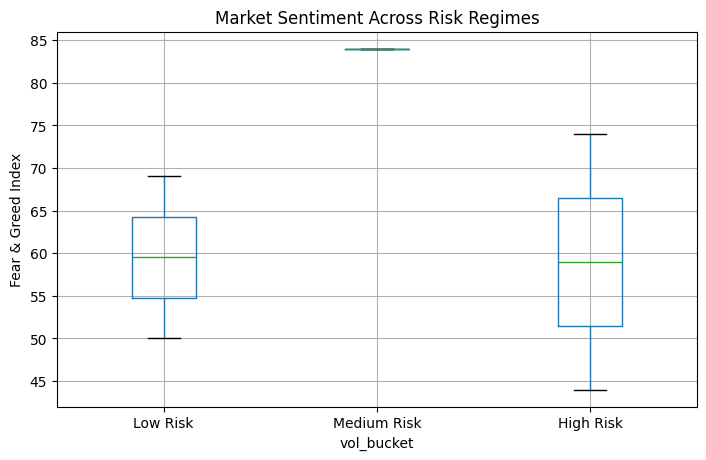

In [95]:
analysis_df.boxplot(
    column="sentiment",
    by="vol_bucket",
    figsize=(8, 5)
)
plt.title("Market Sentiment Across Risk Regimes")
plt.suptitle("")
plt.ylabel("Fear & Greed Index")
plt.show()


In [101]:
# Define target: 1 if day is profitable, else 0
daily_market["profitable_day"] = (daily_market["avg_pnl"] > 0).astype(int)

# Check balance
daily_market["profitable_day"].value_counts()


,count
profitable_day,
1,6
0,1


In [106]:
# Combine features and target
model_data = daily_market[feature_cols + ["profitable_day"]].copy()

# Drop rows with NaNs (from lagging)
model_data = model_data.dropna()

# Split X and y
X = model_data[feature_cols]
y = model_data["profitable_day"]

X.shape, y.shape




profitable_day
1    6
Name: count, dtype: int64


In [108]:
daily_market["profitable_day"].value_counts()



,count
profitable_day,
1,6
0,1


In [109]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(
    daily_market[feature_cols].dropna()
)

X_scaled = pd.DataFrame(
    X_scaled,
    columns=feature_cols,
    index=daily_market[feature_cols].dropna().index
)


In [110]:
# Weighted score (weights can be justified in report)
daily_market.loc[X_scaled.index, "prob_good_day"] = (
    0.35 * X_scaled["sentiment_lag1"] +
    0.25 * X_scaled["win_rate_lag1"] +
    0.20 * X_scaled["trade_intensity_lag1"] +
    0.20 * X_scaled["avg_position_lag1"]
)


In [111]:
def trade_decision(prob):
    if prob >= 0.65:
        return "Trade"
    elif prob >= 0.45:
        return "Reduced Trade"
    else:
        return "Skip"

daily_market["trade_decision"] = daily_market["prob_good_day"].apply(trade_decision)


In [112]:
BASE_CAPITAL = 10_000  # ₹10k example

daily_market["recommended_investment"] = (
    BASE_CAPITAL * daily_market["prob_good_day"]
).round(0)

daily_market["estimated_max_loss"] = (
    daily_market["recommended_investment"] * 0.02  # 2% risk cap
).round(0)


In [113]:
final_csv = daily_market[[
    "date",
    "prob_good_day",
    "trade_decision",
    "recommended_investment",
    "estimated_max_loss"
]]

final_csv.to_csv("daily_trade_recommendations.csv", index=False)
